In [5]:
import numpy as np
import pylab as plt
import requests
import io
import pymc as pm

from scipy import stats, linalg
import nfl_data_py as nfl

## Recreating Fantasy Math

[Fantasy Math](https://www.nathanbraun.com/fantasymath/) model used to help set fantasy football line-ups. Models the player outputs as a function of their [ECR](https://www.fantasypros.com/nfl/rankings/ppr-wr-cheatsheets.php).

In [6]:
class Player:
    def __init__(self, alpha, beta, player_name=None, team=None, position=None):
        """
        """
        self.name = player_name
        self.team = team
        self.position = position
        self.alpha = alpha
        self.beta = beta

    def _populate_statistics(self):
        """
        Take information from a table and load it into a dictionary
        """
        self.statistics = {}
        
    def _get_weekly_ecr(self):
        """
        """
        pass
    
    def _cls(self):
        """
        """
        pass

Procedure for generating correlated samples

1. Define distributions associated with each random variable (player score)
    1. This comes from historical data associated with the player ECR
2. Define correlations between random variables
    1. Again historical data
3. Sample from correlated distributions
    1. asdf

In [7]:
alpha_x = 4.0 # Shape parameter for X
beta_x = 1.0 # Rate parameter for X

alpha_y = 3.0
beta_y = 0.5 

# Degree of correlation
correlation = 0.5

# Define the covariance matrix
corr = np.array([
    [1, correlation], [correlation, 1]
])


nsamples = 50000
samples_correlated = np.random.multivariate_normal(np.zeros(2), corr, size=nsamples)

In [8]:
samples_x = stats.gamma.ppf(
    stats.norm.cdf(samples_correlated[:, 0]),
    alpha_x,
    scale=beta_x ** -1,
)

samples_y = stats.gamma.ppf(
    stats.norm.cdf(samples_correlated[:, 1]),
    alpha_y,
    scale=beta_y ** -1,
)

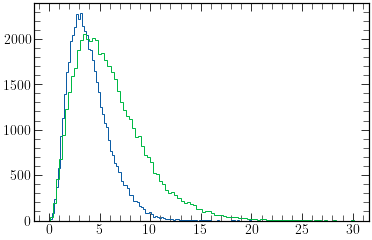

In [9]:
plt.figure()
plt.hist(np.random.gamma(alpha_x, 1 / beta_x, size=nsamples), bins=100, histtype='step')
plt.hist(np.random.gamma(alpha_y, 1 / beta_y, size=nsamples), bins=100, histtype='step')
plt.show()

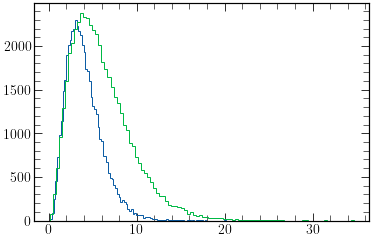

In [10]:
plt.figure()
plt.hist(samples_x, bins=100, histtype='step')
plt.hist(samples_y, bins=100, histtype='step')
plt.show()

## Teams

In [11]:
def generate_samples(dist_params, correlation, nsamples=1000):
    """
    """
    assert len(dist_params) == correlation.shape[0], "A"

    # asdf
    samples = np.random.multivariate_normal(
        np.zeros(correlation.shape[0]), correlation, nsamples
    )

    players = []
    for player_ind, (alpha, beta) in enumerate(dist_params):
        player_samples = stats.gamma.ppf(
            stats.norm.cdf(samples[:, player_ind]), alpha, scale=beta ** -1,
        )
        players.append(player_samples)

    return np.array(players)

def fit_gamma_distribution(statistics, method='MLE', loc=0.0):
    """
    """
    if method == "MLE":
        shape, _, scale = stats.gamma.fit(statistics, floc=loc)
        
    elif method == 'Bayes':
        shape, scale = None, None 
    
    else:
        raise ValueError(f"Method, {method}, is currently unsupoorted")
    return 

In [12]:
# Generate mock rosters and correlations between players
nplayers = 10
dist_params1 = list(zip(np.full(nplayers, 10), np.linspace(0.5, 0.5, nplayers)))
dist_params2 = list(zip(np.full(nplayers, 10), np.linspace(0.1, 0.2, nplayers)))

nsamples = 10000
used_off_diagonal_terms = True

if used_off_diagonal_terms:
    correlation = np.random.uniform(0, 0.25, size=(10, 10))
    correlation[np.diag_indices_from(correlation)] = 1
    correlation = (correlation + correlation.T) / 2
else:
    correlation = np.diag(np.ones(nplayers))

team1 = generate_samples(dist_params1, correlation, nsamples=nsamples)
team2 = generate_samples(dist_params2, correlation, nsamples=nsamples)

In [13]:
params = [stats.gamma.fit(team1[i], floc=0.0) for i in range(team1.shape[0])]

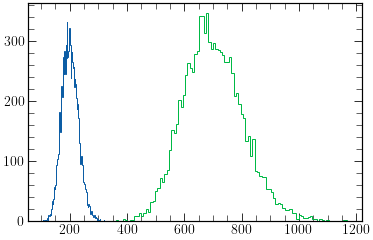

In [14]:
plt.figure()
plt.hist(team1.sum(0), bins=100, histtype='step')
plt.hist(team2.sum(0), bins=100, histtype='step')
plt.show()

In [15]:
from scipy import special

def win_probability(team1, team2):
    """
    Gives the probability of team 1 scoring a higher than team 2 assuming team 1 and team 2
    are Gaussian distributed
    """
    mu1 = np.mean(team1)
    mu2 = np.mean(team2)
    mu = mu1 - mu2
    
    var1 = np.var(team1)
    var2 = np.var(team2)
    var = var1 + var2
    
    return special.erfc(-mu / np.sqrt(2 * var)) / 2

In [16]:
X = np.sum(team1, axis=0)
Y = np.sum(team2, axis=0)

### Bayesian Modeling

Another approach we can take to modeling the distribution of player outcomes, is by performing an MCMC fit of a Gamma distribution to the data. This approach allows us to account of uncertainties in our estimate of the Gamma distribution and incorporate those incertainties into the sampling. This approach is far slower, but in theory, produces samples which better match the true points distribution.

Posteriors look roughly Gaussian. Perhaps the best thing to do would be to fit the MCMC to the true distributions. After computing the mean and covariance of the posteriors, we can generate $\alpha$ and $\beta$ samples from a multivariate Gaussian distribution. We can then use these $\alpha$ and $\beta$ values to sample from Gamma distributions to simulate.

In [17]:
# Sample data (replace with your own dataset)
x = np.linspace(0, 20, 500)
#P = stats.norm.pdf(x, 2, 1) + stats.norm.pdf(x, 4., 1.7)
#P /= P.sum()
#data = np.random.choice(x, p=P, size=500)
data = stats.gamma.rvs(5, scale=2, size=500)

#P = (stats.gamma.pdf(x, 5, scale=2) + stats.gamma.pdf(x, 12, scale=1))
#P /= P.sum()
#data = np.random.choice(x, p=P, size=500)

# Define a PyMC3 model
with pm.Model() as model:
    # Define the parameters of the gamma distribution
    #shape = pm.Exponential("shape", lam=1.0)
    #rate = pm.Exponential("rate", lam=1.0)
    shape = pm.Uniform("shape", lower=3, upper=7)
    rate = pm.Uniform("rate", lower=0.1, upper=1)
    
    # Define the likelihood using the gamma distribution
    likelihood = pm.Gamma("likelihood", alpha=shape, beta=rate, observed=data)
    
    # Perform Bayesian inference
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [shape, rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 66 seconds.


In [18]:
mu_shape, _ = trace.posterior.shape.mean(), trace.posterior.shape.std()
mu_rate, _ = trace.posterior.rate.mean(), trace.posterior.rate.std()

shape, rate = np.array(trace.posterior.shape), np.array(trace.posterior.rate)
C = np.cov(np.column_stack([shape.ravel(), rate.ravel()]).T)
SHAPE, RATE = np.random.multivariate_normal(np.array([mu_shape, mu_rate]), C, size=1000).T

In [19]:
std = np.std([stats.gamma.pdf(x, SHAPE[i], scale=RATE[i] ** -1) for i in range(1000)], axis=0)
mean = np.mean([stats.gamma.pdf(x, SHAPE[i], scale=RATE[i] ** -1) for i in range(1000)], axis=0)

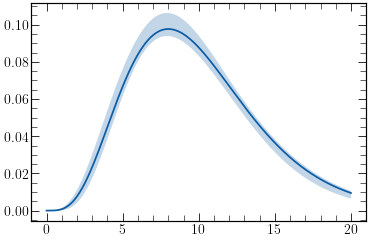

In [20]:
plt.fill_between(x, mean - 1.96 * std, mean + 1.96 * std, alpha=0.25)
plt.plot(x, stats.gamma.pdf(x, 5, scale=2))
#plt.plot(x, 25 * P)

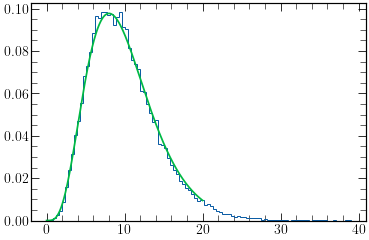

In [21]:
plt.hist(np.random.gamma(shape.ravel(), rate.ravel() ** -1), bins=100, histtype='step', density=True)
plt.plot(x, stats.gamma.pdf(x, 5, scale=2))

## Correlations

In [22]:
import pandas as pd
import fantasy_math

In [23]:
%%time
years = range(2019, 2023)
columns = [
    "player_name",
    "recent_team",
    "week",
    "position",
    "fantasy_points_ppr",
    "season_type",
    "season",
]
data = nfl.import_weekly_data(years=years, columns=columns)
schedule = nfl.import_schedules(years=years)

Downcasting floats.
CPU times: user 326 ms, sys: 98.8 ms, total: 425 ms
Wall time: 4.54 s


In [24]:
%%time
weeks = np.arange(1, 17)
positions = {k: v for k, v in zip(['QB', 'RB', 'WR', 'TE'], [1, 2, 3, 1])}

# Positions tracked and number of each
rows = []
for year in years:
    year_data = data[data.season == year]
    teams = year_data.recent_team.unique()
    
    for week in weeks:
        subtable = year_data[year_data.week == week]
        matchups = schedule[(schedule.week == week) & (schedule.season == year)]
        
        for (home_team, away_team) in zip(matchups.home_team, matchups.away_team):
            
            home_team_table = subtable[subtable.recent_team == home_team]
            away_team_table = subtable[subtable.recent_team == away_team]
            
            row = []
            for position, pnum in positions.items():
                pos_table = home_team_table[home_team_table.position == position]
                pos_table = pos_table.sort_values('fantasy_points_ppr', ascending=False)
                pos_row = list(pos_table[:pnum].fantasy_points_ppr)
                pos_row = pos_row + [0] * max(0, pnum - len(pos_row))
                row += pos_row
                
            for position, pnum in positions.items():
                pos_table = away_team_table[away_team_table.position == position]
                pos_table = pos_table.sort_values('fantasy_points_ppr', ascending=False)
                pos_row = list(pos_table[:pnum].fantasy_points_ppr)
                pos_row = pos_row + [0] * max(0, pnum - len(pos_row))
                row += pos_row

            rows.append(row)

CPU times: user 6.41 s, sys: 32.8 ms, total: 6.44 s
Wall time: 6.45 s


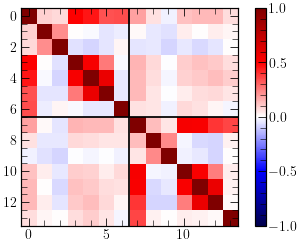

In [25]:
plt.figure()
corr = np.corrcoef(np.array(rows).T)
plt.imshow(corr, cmap='seismic', vmin=-1, vmax=1)
plt.axhline(6.5, color='k')
plt.axvline(6.5, color='k')
plt.colorbar()

## All the Pieces

In [39]:
%%time
n_sims = 10000 # number of simulations

# Sample shape and rate parameters from covariance matrix (do this for every player)
SHAPES = []
RATES = []
for ms in list(np.linspace(0, 0.5, 7)) + list(np.linspace(-0.5, 0, 7)):
    SHAPE, RATE = np.random.multivariate_normal(np.array([mu_shape + ms, mu_rate]), C, size=n_sims).T
    SHAPES.append(SHAPE)
    RATES.append(RATE)
# Generate random correlation matrix
# corr = np.random.uniform(0, 0.1, size=(10, 10))
# corr = (corr + corr.T) / 2
# corr[np.diag_indices_from(corr)] = 1

# Samples from correlation matrix
samples_correlated = np.random.multivariate_normal(np.zeros(corr.shape[0]), corr, size=n_sims)

CPU times: user 27.8 ms, sys: 6.33 ms, total: 34.1 ms
Wall time: 37.3 ms


In [40]:
%%time
all_samples = []
for player_ind in range(corr.shape[0]):
    samples_x = stats.gamma.ppf(
        stats.norm.cdf(samples_correlated[:, player_ind]),
        SHAPES[player_ind],
        scale=RATES[player_ind] ** -1,
    )
    all_samples.append(samples_x)
    
all_samples = np.array(all_samples)

CPU times: user 133 ms, sys: 5.17 ms, total: 138 ms
Wall time: 140 ms


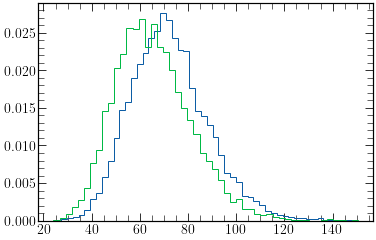

In [41]:
plt.figure()
plt.hist(np.sum(all_samples[:7], axis=0), histtype='step', density=True, bins=50)
plt.hist(np.sum(all_samples[7:], axis=0), histtype='step', density=True, bins=50)
plt.show()

In [42]:
np.mean(np.sum(all_samples[:7], axis=0) < np.sum(all_samples[7:], axis=0))

0.3666

In [43]:
win_probability(np.sum(all_samples[:7], axis=0), np.sum(all_samples[7:], axis=0))

0.6176571268926477

In [44]:
from scipy import interpolate, integrate, stats

In [45]:
kde_m = stats.gaussian_kde(np.sum(all_samples[:7], axis=0))
kde_n = stats.gaussian_kde(np.sum(all_samples[7:], axis=0))

In [46]:
m = np.sort(np.sum(all_samples[:7], axis=0))
n = np.sort(np.sum(all_samples[7:], axis=0))

ecdf = np.arange(1, len(m) + 1) / len(m)

cdf_m = interpolate.interp1d(m, ecdf, fill_value=(0, 1), bounds_error=False)
cdf_n = interpolate.interp1d(n, ecdf, fill_value=(0, 1), bounds_error=False)

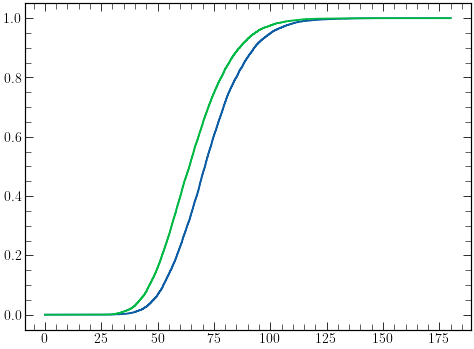

In [47]:
# Calculate the ECDF
x = np.linspace(0, 180, 1000)

# Plot the ECDF
plt.figure(figsize=(8, 6))
plt.step(x, cdf_m(x))
plt.step(x, cdf_n(x))
plt.show()

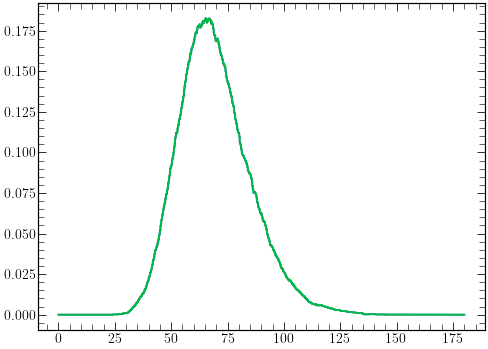

In [51]:
plt.figure(figsize=(8, 6))
plt.step(x, np.abs(cdf_m(x) - cdf_n(x)))
plt.step(x, np.abs(cdf_n(x) - cdf_m(x)))
plt.show()

In [53]:
x1 = np.linspace(0, 180, 1000)


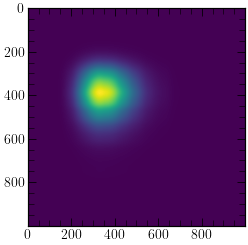

In [56]:
plt.imshow(np.outer(kde_m(x1), kde_n(x1)))

In [59]:
integrate.dblquad(lambda x, y: kde_m(x) * kde_n(y), 0, 180, 0, lambda x: x)

(0.3797629842347921, 1.4891211925926442e-08)

In [149]:
# This creates a table of player performance for a given season
players = nfl.import_weekly_data([2022], thread_requests=True)
players = players[players.week < 18]
players = players.pivot_table(index="player_name", columns=['season', 'week'], values='fantasy_points_ppr')
players.fillna(0, inplace=True)
players['Total'] = players.sum(1, numeric_only=True)
players = players.sort_values("Total", ascending=False)

Downcasting floats.


In [178]:
# Identify the top performing players by each position
players = nfl.import_weekly_data([2022], thread_requests=True)
players = players[players.week < 18]

positions = ["QB", "TE", "WR", "RB"]
nplayers_to_track = {"QB": 1, "TE": 2, "WR": 3, "RB": 2}
teams = players.recent_team.unique()

rankings = {team: {pos: [] for pos in positions} for team in teams}

for team in teams:
    for pos in positions:
        tb = players[(players.position == pos) & (players.recent_team == team)].pivot(
            index="player_name", columns=["season", "week"], values="fantasy_points_ppr"
        )
        tb['Total'] = tb.sum(1, numeric_only=True)
        tb = tb.sort_values("Total", ascending=False)
        
        rankings[team][pos] = tb.index[:nplayers_to_track[pos]]

Downcasting floats.


In [186]:
team = rankings['SF']

tot = []
for pos in team:
     for player in team[pos]:
        print (player, players[players.player_name == player].shape)

J.Garoppolo (11, 52)
G.Kittle (14, 52)
R.Dwelley (4, 52)
B.Aiyuk (16, 52)
D.Samuel (12, 52)
J.Jennings (15, 52)
C.McCaffrey (16, 52)
J.Wilson (15, 52)


In [238]:
table = nfl.import_depth_charts([2022])

In [240]:
for cc in table.club_code.unique():
    az = table[
        (table.week == 6)
        & (table.club_code == cc)
        & (table.formation == "Offense")
        & (table.position == "TE")
    ]
    if cc == "IND":
        break
    print(cc, az.value_counts("depth_team"))

ATL depth_team
3    2
1    1
2    1
dtype: int64
BUF depth_team
1    1
2    1
3    1
dtype: int64
CHI depth_team
3    2
1    1
2    1
dtype: int64
CIN depth_team
1    1
2    1
3    1
dtype: int64
BAL depth_team
3    2
1    1
2    1
dtype: int64
DAL depth_team
1    1
2    1
3    1
dtype: int64
DEN depth_team
3    2
1    1
2    1
dtype: int64
DET depth_team
1    1
2    1
3    1
dtype: int64
GB depth_team
3    2
1    1
2    1
dtype: int64
TEN depth_team
1    2
2    2
dtype: int64


In [241]:
az

,season,club_code,week,game_type,depth_team,last_name,first_name,football_name,formation,gsis_id,jersey_number,position,elias_id,depth_position,full_name
12617,2022,IND,6,REG,1,Alie-Cox,Mo,Mo,Offense,00-0033217,81,TE,ALI177980,TE,Mo Alie-Cox
12633,2022,IND,6,REG,1,Granson,Kylen,Kylen,Offense,00-0036876,83,TE,GRA367521,TE,Kylen Granson
12635,2022,IND,6,REG,2,Woods,Jelani,Jelani,Offense,00-0037755,80,TE,WOO500422,TE,Jelani Woods
